# Progetto di A.I. & Deep Learning 
## Intrusion Detection System (NSL-KDD Dataset)


---


### Giulia Maraventano
#### Università degli Studi di Palermo - Corso di Laurea Magistrale in Informatica

In [2]:
# Import librerie
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow import keras

## Estrazione e organizzazione dei dati

In [3]:
# Lettura dati
train_file = '/content/drive/MyDrive/AI/Progetto/Data/KDDTrain+.txt'
test_file = '/content/drive/MyDrive/AI/Progetto/Data/KDDTest+.txt' 

train_df = pd.read_csv(train_file, header=None)
test_df = pd.read_csv(test_file, header=None)

In [4]:
# Header
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'target'
,'level'])

train_df.columns = columns
test_df.columns = columns

In [5]:
train_df.head()

duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60                         0.88   
2                    0.05                         0.00   
3                    0.00                         0.03   
4                    0.00                         0.00   

   dst_host_srv_diff_host_rate  dst_host_serror_rate  \
0                         0.00                  0.00   
1                         0.00                  0.00   
2                         0.00                  1.00   
3                         0.04                  0.03   
4                         0.00                  0.00   

   dst_host_srv_serror_rate  dst_host_rerror_rate  dst_host_srv_rerror_rate  \
0                      0.00                  0.05                      0.00   
1                      0.00                  0.00                      0.00   
2                      1.00                  0.00                      0.00   
3                      0.01                  0.00                      0.01   
4                      0.00                  0.00                      0.00   

    target  level  
0   normal     20  
1   normal     15  
2  neptune     19  
3   normal     21  
4   normal     21  

[5 rows x 43 columns]

In [6]:
test_df.head()

duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         0           tcp   private   REJ          0          0     0   
1         0           tcp   private   REJ          0          0     0   
2         2           tcp  ftp_data    SF      12983          0     0   
3         0          icmp     eco_i    SF         20          0     0   
4         1           tcp    telnet  RSTO          0         15     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.04   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.61   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    0.31   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.06                         0.00   
1                    0.06                         0.00   
2                    0.04                         0.61   
3                    0.00                         1.00   
4                    0.17                         0.03   

   dst_host_srv_diff_host_rate  dst_host_serror_rate  \
0                         0.00                   0.0   
1                         0.00                   0.0   
2                         0.02                   0.0   
3                         0.28                   0.0   
4                         0.02                   0.0   

   dst_host_srv_serror_rate  dst_host_rerror_rate  dst_host_srv_rerror_rate  \
0                       0.0                  1.00                      1.00   
1                       0.0                  1.00                      1.00   
2                       0.0                  0.00                      0.00   
3                       0.0                  0.00                      0.00   
4                       0.0                  0.83                      0.71   

    target  level  
0  neptune     21  
1  neptune     21  
2   normal     21  
3    saint     15  
4    mscan     11  

[5 rows x 43 columns]

In [7]:
train_df.shape

(125973, 43)

In [8]:
test_df.shape

(22544, 43)

Ci sono 43 colonne (features) di cui 3 dati categorici, 1 class label e 39 attributi numerici

In [9]:
# Conversione delle categorie di attacco in macrocategorie (Normal,Dos,Probe,U2R,R2L)
def macro_target(df):
  df.target.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.target.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail',
       'snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
  df.target.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.target.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

macro_target(train_df)
macro_target(test_df)

train_df['label'] = LabelEncoder().fit_transform(train_df['target'])
test_df['label'] = LabelEncoder().fit_transform(test_df['target'])

train_df.head()

duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_diff_srv_rate  \
0               0       0    0  ...                    0.03   
1               0       0    0  ...                    0.60   
2               0       0    0  ...                    0.05   
3               0       0    0  ...                    0.00   
4               0       0    0  ...                    0.00   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.17                         0.00   
1                         0.88                         0.00   
2                         0.00                         0.00   
3                         0.03                         0.04   
4                         0.00                         0.00   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                  0.00                      0.00                  0.05   
1                  0.00                      0.00                  0.00   
2                  1.00                      1.00                  0.00   
3                  0.03                      0.01                  0.00   
4                  0.00                      0.00                  0.00   

   dst_host_srv_rerror_rate  target  level  label  
0                      0.00  normal     20      4  
1                      0.00  normal     15      4  
2                      0.00     Dos     19      0  
3                      0.01  normal     21      4  
4                      0.00  normal     21      4  

[5 rows x 44 columns]

In [10]:
test_df.head()

duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         0           tcp   private   REJ          0          0     0   
1         0           tcp   private   REJ          0          0     0   
2         2           tcp  ftp_data    SF      12983          0     0   
3         0          icmp     eco_i    SF         20          0     0   
4         1           tcp    telnet  RSTO          0         15     0   

   wrong_fragment  urgent  hot  ...  dst_host_diff_srv_rate  \
0               0       0    0  ...                    0.06   
1               0       0    0  ...                    0.06   
2               0       0    0  ...                    0.04   
3               0       0    0  ...                    0.00   
4               0       0    0  ...                    0.17   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.00                         0.00   
1                         0.00                         0.00   
2                         0.61                         0.02   
3                         1.00                         0.28   
4                         0.03                         0.02   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                   0.0                       0.0                  1.00   
1                   0.0                       0.0                  1.00   
2                   0.0                       0.0                  0.00   
3                   0.0                       0.0                  0.00   
4                   0.0                       0.0                  0.83   

   dst_host_srv_rerror_rate  target  level  label  
0                      1.00     Dos     21      0  
1                      1.00     Dos     21      0  
2                      0.00  normal     21      4  
3                      0.00   Probe     15      1  
4                      0.71   Probe     11      1  

[5 rows x 44 columns]



---



## Esplorazione dei dati

### Distribuzione delle macro-categorie nel training set e nel test set

In [11]:
train_attacks = train_df.target.value_counts()
train_attacks

normal    67343
Dos       45927
Probe     11656
R2L         995
U2R          52
Name: target, dtype: int64

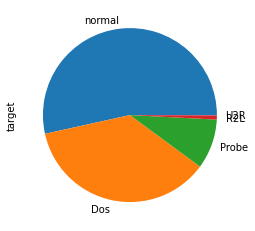

In [12]:
train_attacks.plot(kind="pie")
plt.show()

Si nota un evidente sbilanciamento tra le classi del target. Pochi dati sugli attacchi di tipo U2R e R2L.

In [13]:
test_attacks = test_df.target.value_counts()
test_attacks

normal    9711
Dos       7460
R2L       2885
Probe     2421
U2R         67
Name: target, dtype: int64

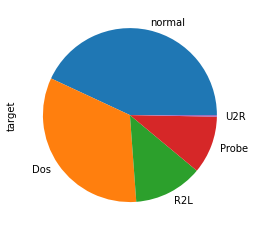

In [14]:
test_attacks.plot(kind="pie")
plt.show()

In entrambi i dataset la maggior parte del traffico è ovviamente normale, ma tra gli attacchi, il più frequente è l'attacco Dos.\
Nel training set c'è una bassissima frequenza di attacchi di tipo R2L, rispetto al test set.

### Distribuzione dei protocolli nel training set e nel test set

In [15]:
train_protocols = train_df.protocol_type.value_counts()
train_protocols

tcp     102689
udp      14993
icmp      8291
Name: protocol_type, dtype: int64

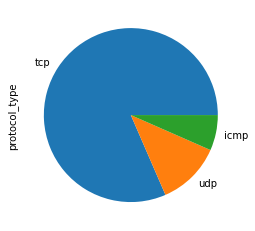

In [16]:
train_protocols.plot(kind="pie")
plt.show()

In [17]:
test_protocols = test_df.protocol_type.value_counts()
test_protocols

tcp     18880
udp      2621
icmp     1043
Name: protocol_type, dtype: int64

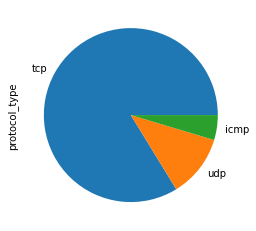

In [18]:
test_protocols.plot(kind="pie")
plt.show()

Il protocollo più utilizzato è il TCP

### Distribuzione dei protocolli di rete per ogni macro-categoria di attacco (nel training set)

In [19]:
train_category_vs_protocol = pd.crosstab(train_df.protocol_type, train_df.target)
train_category_vs_protocol

target           Dos  Probe  R2L  U2R  normal
protocol_type                                
icmp            2847   4135    0    0    1309
tcp            42188   5857  995   49   53600
udp              892   1664    0    3   12434

Si nota che ovviamente l'attacco Dos utilizza anche il protocollo icmp, che si trova al layer 3 (Network) del modello ISO/OSI, e anche l'attacco Probe.\
Mentre i due attacchi R2L e U2R sono al livello 4 (Transport), quindi usano soltanto il protocollo TCP.\
Un normale traffico di rete utilizza tutti e 3 i tipi di protocollo.

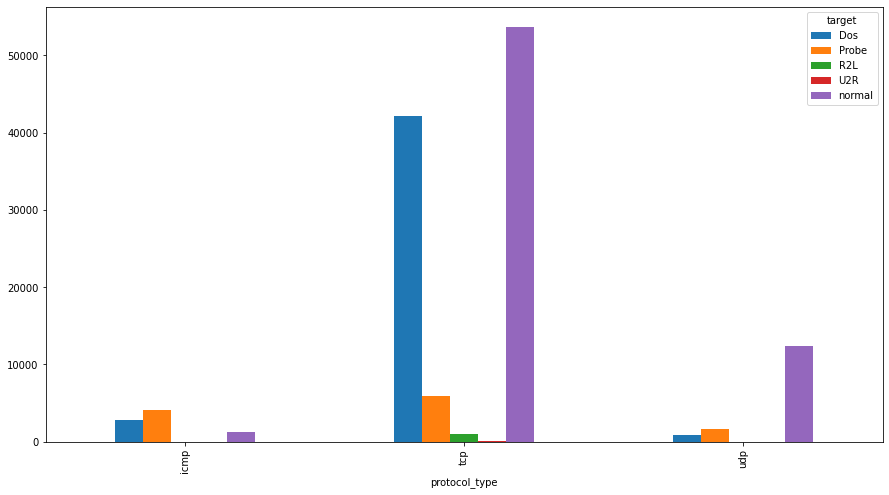

In [20]:
train_category_vs_protocol.plot(kind="bar", figsize=(15,8))
plt.show()

Tutti gli attacchi utilizzano maggiormente il protocollo TCP.\
R2L e U2R utilizzano esclusivamente il TCP

### Distribuzione dei servizi nel training set e nel test

In [21]:
train_services = train_df.service.value_counts()
train_services

http         40338
private      21853
domain_u      9043
smtp          7313
ftp_data      6860
             ...  
tftp_u           3
http_8001        2
aol              2
harvest          2
http_2784        1
Name: service, Length: 70, dtype: int64

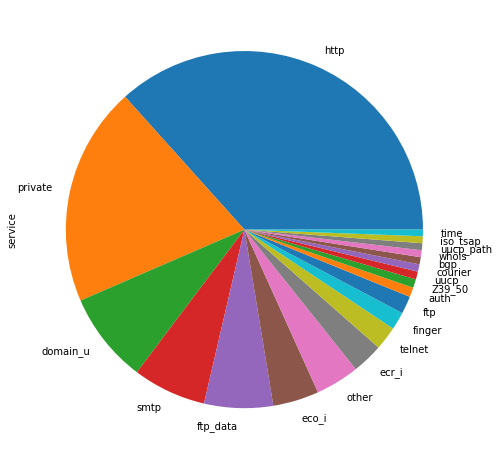

In [22]:
train_services[:20].plot(kind="pie", figsize=(8,10))
plt.show()

In [23]:
test_services = test_df.service.value_counts()
test_services

http       7853
private    4774
telnet     1626
pop_3      1019
smtp        934
           ... 
printer      11
ntp_u        10
rje           8
tim_i         6
tftp_u        1
Name: service, Length: 64, dtype: int64

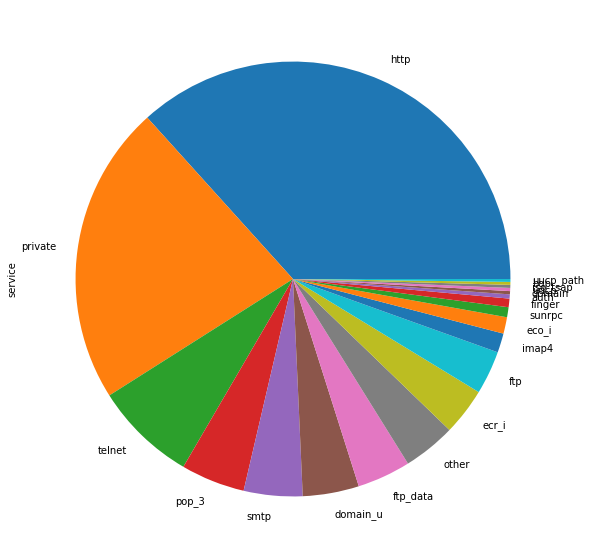

In [24]:
test_services[:20].plot(kind="pie", figsize=(10,10))
plt.show()

Il training set utilizza 70 servizi.\
Il test set ne utilizza 64.\
Il servizio più frequente è l'HTTP.

### Distribuzione dei servizi per ogni macrocategoria di attacco (nel training set)

In [25]:
category_vs_service = pd.crosstab(train_df.service,train_df.target)
category_vs_service

target     Dos  Probe  R2L  U2R  normal
service                                
IRC          0      1    0    0     186
X11          0      6    0    0      67
Z39_50     851     11    0    0       0
aol          0      2    0    0       0
auth       703     16    0    0     236
...        ...    ...  ...  ...     ...
urp_i        0      3    0    0     599
uucp       769     11    0    0       0
uucp_path  676     13    0    0       0
vmnet      606     11    0    0       0
whois      670     23    0    0       0

[70 rows x 5 columns]

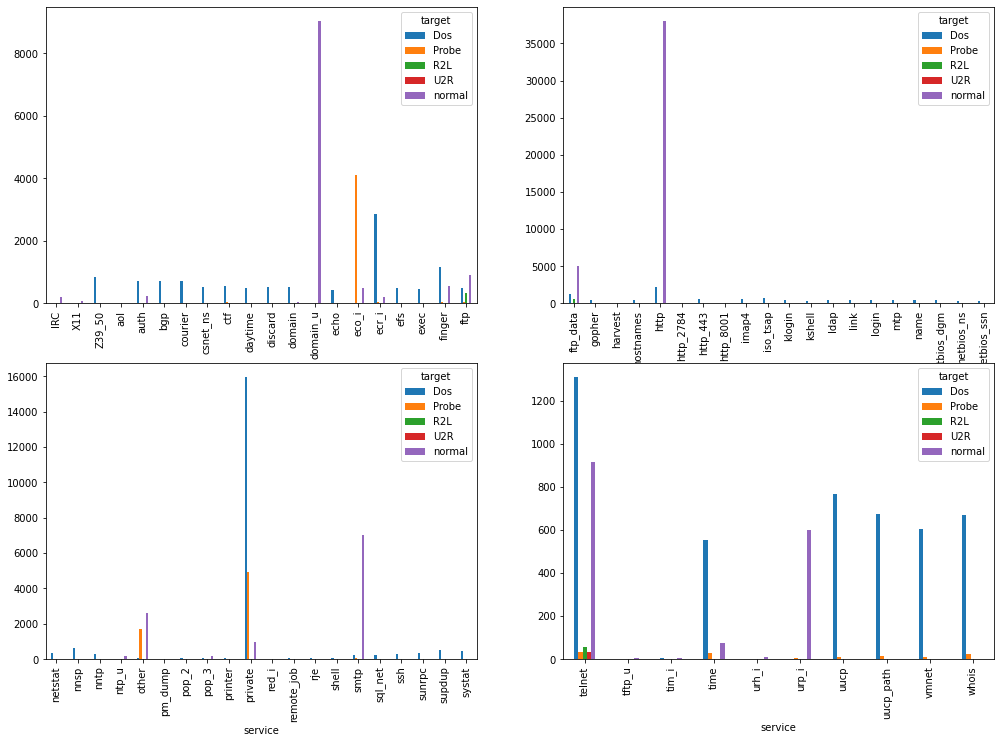

In [26]:
fig, axes = plt.subplots(figsize=(17,12),nrows=2, ncols=2)

category_vs_service[:20].plot(ax=axes[0,0], kind='bar', grid=False)
category_vs_service[20:40].plot(ax=axes[0,1], kind='bar', grid=False)
category_vs_service[40:60].plot(ax=axes[1,0], kind='bar', grid=False)
category_vs_service[60:70].plot(ax=axes[1,1], kind='bar', grid=False)

plt.show()

SERVIZI USATI MAGGIORMENTE:

NORMAL: HTTP (56%)\
DOS: PRIVATE (35%)\
PROBE: PRIVATE (42%)\
R2L: FTP_DATA (60%)\
U2R: TELNET (50%)

### Distribuzione dei flag per ogni macrocategoria di attacco (nel training set)

In [27]:
category_vs_flag = pd.crosstab(train_df.flag,train_df.target)
category_vs_flag

target    Dos  Probe  R2L  U2R  normal
flag                                  
OTH         0     35    0    0      11
REJ      5671   2869    0    0    2693
RSTO     1216     80   46    1     219
RSTOS0      0    103    0    0       0
RSTR       90   2180    5    0     146
S0      34344    153    0    0     354
S1          2      1    1    0     361
S2          5      2    1    0     119
S3          0      1    3    0      45
SF       4599   5967  935   51   63393
SH          0    265    4    0       2

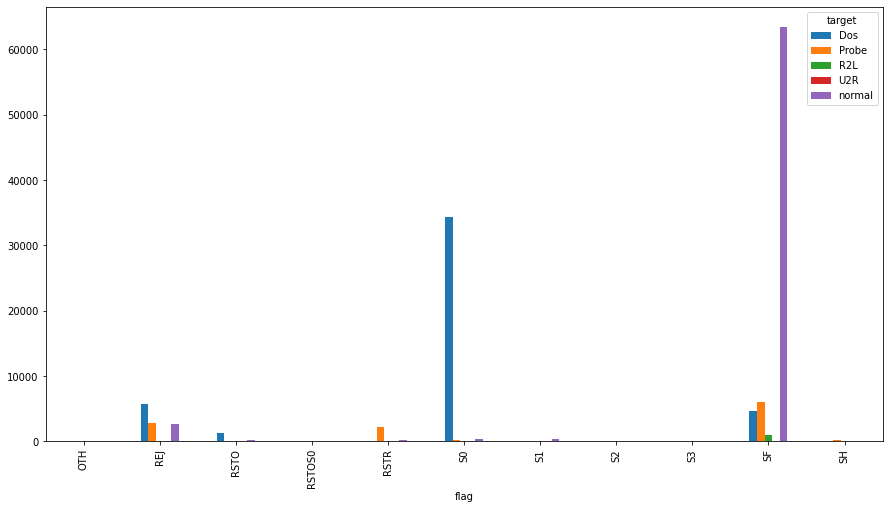

In [28]:
category_vs_flag.plot(kind="bar", figsize=(15,8))
plt.show()



---



## Preelaborazione dei dati

### Codifica dei dati categorici (protocol-type, service, flag)
Label encoding per service\
One-hot encoding per protocol-type e flag

In [29]:
# Label encoding per la feature "service"
train_df['service'] = LabelEncoder().fit_transform(train_df['service'])
test_df['service'] = LabelEncoder().fit_transform(test_df['service'])

# One-hot encoding per le features "protocol_type" e "flag"
train_df = pd.get_dummies(train_df, columns = ['protocol_type', 'flag'])
test_df = pd.get_dummies(test_df, columns = ['protocol_type', 'flag'])

In [30]:
# estrazione del label ed eliminazione target
y_train = train_df['label']
X_train = train_df.drop(columns=['label','target'])

y_test = test_df['label']
X_test = test_df.drop(columns=['label','target'])

Con la codifica one-hot e con l'eliminazione dei dati categorici, il numero totale di Features diventa 54.

### ADASYN data augmentation
(per ovviare allo squilibrio delle classi riscontrato durante il data exploration) 

In [31]:
print("Distribuzione originale delle labels")
y_train.value_counts()

Distribuzione originale delle labels


4    67343
0    45927
1    11656
2      995
3       52
Name: label, dtype: int64

In [32]:
ada = ADASYN(random_state=0)
X_ada, y_ada = ada.fit_resample(X_train, y_train)
print("Distribuzione finale delle labels")
y_ada.value_counts()

Distribuzione finale delle labels


1    67510
2    67344
4    67343
3    67336
0    67238
Name: label, dtype: int64

### Normalizzazione dei dati

In [33]:
scaler = MinMaxScaler()

# ADASYN
X_ada_scaled = scaler.fit_transform(X_ada)
# NO ADASYN
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.fit_transform(X_test)



---


## Modello ML base


---



### Random Forest

In [34]:
RFmodel = RandomForestClassifier(random_state=0)

#RFmodel.fit(X_train_scaled, y_train)
RFmodel.fit(X_ada_scaled, y_ada)

RFpredictions = RFmodel.predict(X_test_scaled)

acc_score = accuracy_score(RFpredictions,y_test)
print(f"Accuracy: {acc_score}")

Accuracy: 0.8097054648687012


Calcolo TPR e FPR

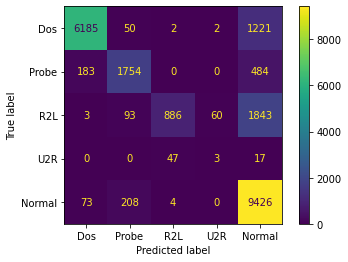

In [35]:
# Stampo il grafico della matrice di confusione per visualizzare le predizioni errate
c_matrix = confusion_matrix(y_test, RFpredictions)
cm_display = ConfusionMatrixDisplay(c_matrix,display_labels=['Dos','Probe','R2L','U2R','Normal']).plot()

In [36]:
FP_RF = c_matrix.sum(axis=0) - np.diag(c_matrix)  
FN_RF = c_matrix.sum(axis=1) - np.diag(c_matrix)
TP_RF = np.diag(c_matrix)
TN_RF = c_matrix.sum() - (FP_RF + FN_RF + TP_RF)

TPR_RF = TP_RF/(TP_RF+FN_RF)*100
FPR_RF = FP_RF/(FP_RF+TN_RF)*100

print(f"TPR Normal: {TPR_RF[4]}% - FPR Normal: {FPR_RF[4]}%")
print(f"TPR Dos: {TPR_RF[0]}% - FPR Dos: {FPR_RF[0]}%")
print(f"TPR Probe: {TPR_RF[1]}% - FPR Probe: {FPR_RF[1]}%")
print(f"TPR R2L: {TPR_RF[2]}% - FPR R2L: {FPR_RF[2]}%")
print(f"TPR U2R: {TPR_RF[3]}% - FPR U2R: {FPR_RF[3]}%")

TPR Normal: 97.06518381217177% - FPR Normal: 27.779942336164577%
TPR Dos: 82.9088471849866% - FPR Dos: 1.7170511800583401%
TPR Probe: 72.44940107393639% - FPR Probe: 1.7442727227550563%
TPR R2L: 30.7105719237435% - FPR R2L: 0.2695966224121268%
TPR U2R: 4.477611940298507% - FPR U2R: 0.27583752280108553%




---



## Modello di rete neurale feedforward

Split del training set (training e validation)

In [37]:
X, X_val, y, y_val = train_test_split(X_ada_scaled, y_ada, test_size=0.20, random_state=0)

print(f"Lunghezza del training: {len(X)}")
print(f"Lunghezza del validation: {len(X_val)}")

Lunghezza del training: 269416
Lunghezza del validation: 67355


Costruzione del modello

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               14080     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                

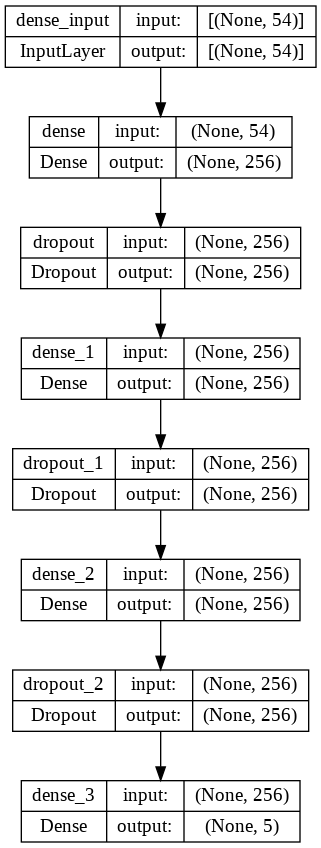

In [38]:
input_shape = X.shape[1:]

NN_model = keras.Sequential(
    [
        keras.layers.Dense(256, activation="relu", input_shape=(input_shape)),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(5, activation="softmax"),
    ]
)
NN_model.summary()

NN_model.compile("adam", "sparse_categorical_crossentropy", metrics="accuracy")

keras.utils.plot_model(NN_model, show_shapes=True, show_layer_names=True)

Training del modello

In [39]:
# parametri
epochs = 10
batch_size = 64
checkpoint_filepath = '/content/drive/MyDrive/AI/Progetto/Best_NN/checkpoint.hdf5'

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

'''
# Addestramento del modello
history = NN_model.fit(X,y,batch_size=batch_size,epochs=epochs,validation_data=(X_val, y_val),callbacks=[checkpoint_callback])

# Grafico dell'andamento dell'accuracy
metric = "accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()
'''

'\n# Addestramento del modello\nhistory = NN_model.fit(X,y,batch_size=batch_size,epochs=epochs,validation_data=(X_val, y_val),callbacks=[checkpoint_callback])\n\n# Grafico dell\'andamento dell\'accuracy\nmetric = "accuracy"\nplt.figure()\nplt.plot(history.history[metric])\nplt.plot(history.history["val_" + metric])\nplt.title("model " + metric)\nplt.ylabel(metric, fontsize="large")\nplt.xlabel("epoch", fontsize="large")\nplt.legend(["train", "val"], loc="best")\nplt.show()\nplt.close()\n'

In [40]:
NN_model.load_weights(checkpoint_filepath)

Valutazione del modello sul test set

In [41]:
test_loss, test_acc = NN_model.evaluate(X_test_scaled, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

705/705 [==============================] - 4s 2ms/step - loss: 2.8863 - accuracy: 0.8258
Test accuracy 0.825762927532196
Test loss 2.8862643241882324


Predizioni sul test set e confronto con i true labels

In [42]:
NNpredictions = NN_model.predict(X_test_scaled)

NNpredictions = np.argmax(NNpredictions,axis = 1)
y_true = np.array(y_test)

705/705 [==============================] - 1s 2ms/step


Matrice di confusione per visualizzare i falsi positivi/negativi

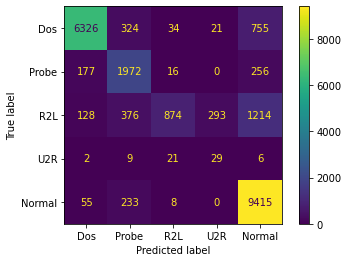

In [43]:
# Stampo il grafico della matrice di confusione per visualizzare le predizioni errate
c_matrix = confusion_matrix(y_true, NNpredictions)
cm_display = ConfusionMatrixDisplay(c_matrix,display_labels=['Dos','Probe','R2L','U2R','Normal']).plot()

Calcolo TPR e FPR

In [44]:
FP_NN = c_matrix.sum(axis=0) - np.diag(c_matrix)  
FN_NN = c_matrix.sum(axis=1) - np.diag(c_matrix)
TP_NN = np.diag(c_matrix)
TN_NN = c_matrix.sum() - (FP_NN + FN_NN + TP_NN)

TPR_NN = TP_NN/(TP_NN+FN_NN)*100
FPR_NN = FP_NN/(FP_NN+TN_NN)*100

print(f"TPR Normal: {TPR_NN[4]}% - FPR Normal: {FPR_NN[4]}%")
print(f"TPR Dos: {TPR_NN[0]}% - FPR Dos: {FPR_NN[0]}%")
print(f"TPR Probe: {TPR_NN[1]}% - FPR Probe: {FPR_NN[1]}%")
print(f"TPR R2L: {TPR_NN[2]}% - FPR R2L: {FPR_NN[2]}%")
print(f"TPR U2R: {TPR_NN[3]}% - FPR U2R: {FPR_NN[3]}%")

TPR Normal: 96.95191020492226% - FPR Normal: 17.384867139406218%
TPR Dos: 84.79892761394102% - FPR Dos: 2.399893927340228%
TPR Probe: 81.45394465097068% - FPR Probe: 4.68121055508622%
TPR R2L: 30.294627383015598% - FPR R2L: 0.4018515692558116%
TPR U2R: 43.28358208955223% - FPR U2R: 1.396983583218401%




---



## Modello di rete CNN LSTM

Modello di rete convolutiva

In [192]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input, Dense, Convolution1D, Activation, MaxPooling1D, Flatten, Dropout, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

cnn = keras.Sequential()
cnn.add(Convolution1D(128, 3, padding="same",activation="relu",input_shape=(X.shape[1], 1)))
cnn.add(Convolution1D(128, 3, padding="same", activation="relu"))
cnn.add(Convolution1D(128, 3, padding="same", activation="relu"))
cnn.add(MaxPooling1D(pool_size=(2)))
cnn.add(LSTM(30))
cnn.add(Dropout(0.1))
cnn.add(Dense(5, activation="softmax"))

cnn.compile(loss="sparse_categorical_crossentropy", optimizer="adam",metrics=['accuracy'])

cnn.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_142 (Conv1D)         (None, 54, 128)           512       
                                                                 
 conv1d_143 (Conv1D)         (None, 54, 128)           49280     
                                                                 
 conv1d_144 (Conv1D)         (None, 54, 128)           49280     
                                                                 
 max_pooling1d_66 (MaxPoolin  (None, 27, 128)          0         
 g1D)                                                            
                                                                 
 lstm_42 (LSTM)              (None, 30)                19080     
                                                                 
 dropout_53 (Dropout)        (None, 30)                0         
                                                     

Epoch 1/10
4210/4210 [==============================] - 32s 7ms/step - loss: 0.1637 - accuracy: 0.9424 - val_loss: 0.0411 - val_accuracy: 0.9887
Epoch 2/10
4210/4210 [==============================] - 30s 7ms/step - loss: 0.0306 - accuracy: 0.9909 - val_loss: 0.0154 - val_accuracy: 0.9955
Epoch 3/10
4210/4210 [==============================] - 30s 7ms/step - loss: 0.0192 - accuracy: 0.9946 - val_loss: 0.0181 - val_accuracy: 0.9943
Epoch 4/10
4210/4210 [==============================] - 30s 7ms/step - loss: 0.0140 - accuracy: 0.9962 - val_loss: 0.0087 - val_accuracy: 0.9977
Epoch 5/10
4210/4210 [==============================] - 31s 7ms/step - loss: 0.0111 - accuracy: 0.9970 - val_loss: 0.0070 - val_accuracy: 0.9978
Epoch 6/10
4210/4210 [==============================] - 30s 7ms/step - loss: 0.0091 - accuracy: 0.9976 - val_loss: 0.0054 - val_accuracy: 0.9984
Epoch 7/10
4210/4210 [==============================] - 28s 7ms/step - loss: 0.0082 - accuracy: 0.9978 - val_loss: 0.0080 - val_ac

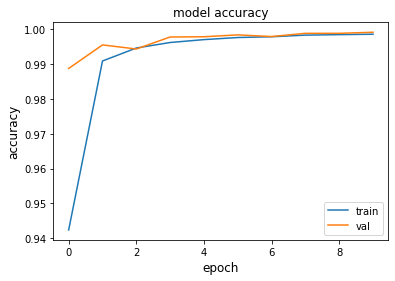

In [193]:
epochs = 10
batch_size = 64
checkpoint_filepath = '/content/drive/MyDrive/AI/Progetto/Best_CNN/checkpoint.hdf5'

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

'''
# Addestramento del modello
history = cnn.fit(X, y, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),callbacks=[checkpoint_callback])

# grafico accuracy
metric = "accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()
'''

In [196]:
cnn.load_weights(checkpoint_filepath)

In [197]:
test_loss, test_acc = cnn.evaluate(X_test_scaled, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

705/705 [==============================] - 3s 4ms/step - loss: 1.4742 - accuracy: 0.8116
Test accuracy 0.8116128444671631
Test loss 1.4741501808166504


In [198]:
CNNpredictions = cnn.predict(X_test_scaled)

CNNpredictions = np.argmax(CNNpredictions,axis = 1)
y_true = np.array(y_test)

705/705 [==============================] - 2s 3ms/step


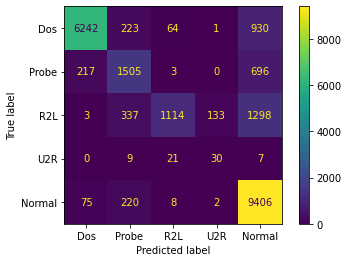

In [199]:
# Stampo il grafico della matrice di confusione per visualizzare le predizioni errate
c_matrix = confusion_matrix(y_true, CNNpredictions)
cm_display = ConfusionMatrixDisplay(c_matrix,display_labels=['Dos','Probe','R2L','U2R','Normal']).plot()

In [200]:
FP_CNN = c_matrix.sum(axis=0) - np.diag(c_matrix)  
FN_CNN = c_matrix.sum(axis=1) - np.diag(c_matrix)
TP_CNN = np.diag(c_matrix)
TN_CNN = c_matrix.sum() - (FP_CNN + FN_CNN + TP_CNN)

TPR_CNN = TP_CNN/(TP_CNN+FN_CNN)*100
FPR_CNN = FP_CNN/(FP_CNN+TN_CNN)*100

print(f"TPR Normal: {TPR_CNN[4]}% - FPR Normal: {FPR_CNN[4]}%")
print(f"TPR Dos: {TPR_CNN[0]}% - FPR Dos: {FPR_CNN[0]}%")
print(f"TPR Probe: {TPR_CNN[1]}% - FPR Probe: {FPR_CNN[1]}%")
print(f"TPR R2L: {TPR_CNN[2]}% - FPR R2L: {FPR_CNN[2]}%")
print(f"TPR U2R: {TPR_CNN[3]}% - FPR U2R: {FPR_CNN[3]}%")

TPR Normal: 96.85923179899083% - FPR Normal: 22.83955427413699%
TPR Dos: 83.67292225201072% - FPR Dos: 1.9557146645452135%
TPR Probe: 62.16439487814952% - FPR Probe: 3.9208865477314516%
TPR R2L: 38.613518197573654% - FPR R2L: 0.4883259575766824%
TPR U2R: 44.776119402985074% - FPR U2R: 0.6050629532410909%




---

